In [32]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
import os

# Analysis of the competition network
1. Load data
2. give the cluster of nodes
3. plot the network
4. caculate the competition of netork across cluster

In [33]:
USE_SIMPLE_DATA = False

In [34]:
# change the path 
path = "/Users/eric/Documents/SchoolCourses/schoolNetwork/reformate"
os.chdir(path)


In [35]:
# load the data
departmentDict = {}
with open("./rawData/cross/university.json") as f:
    universityDict = json.load(f)
for Ukey, Uvalue in universityDict.items():
    with open(f"./rawData/cross/{Ukey}.json") as f:
        department = json.load(f)
    for Skey,Svalue in department.items():
        departmentDict[f"{Ukey}_{Skey}"] = Svalue



In [36]:
# transfer to networkx Graph
with open("./rawData/cross/students.json") as f:
    studentDict = json.load(f)
cluster  = dict()
G = nx.Graph()
it = 0
for key,val in departmentDict.items():
    G.add_node(val,cnname=key)
for dep in studentDict:
    for head, tail in dep.items():
        for link,weight  in tail.items():
            G.add_edge(head,link,weight=weight) 

In [37]:
# load the cluster data set
with open(f"./processedData/{'simplify_tsneCluster.csv' if USE_SIMPLE_DATA else 'raw_tsneCluster.csv'}") as f:
    clusterData = pd.read_csv(f)
clusterMap = {f"{row['學系代碼']:06d}":row['cluster'] for idx,row in clusterData.iterrows()}

Note:  cluster 8 means other

In [38]:
# add cluster to the graph
for node in G.nodes:
    node_ = node.replace("check_","").replace("_NO_1_109_0_3.html","").replace("music_dep_","").replace("_NO_0_109_0_3.html","").replace("_NO_1_109_1_3.html","")
    try :
        G.nodes[node]['cluster'] = clusterMap[node_]
    except:
        G.nodes[node]['cluster'] = 8
    try:
        G.nodes[node]['code'] = node_
    except:
        G.nodes[node]['code'] = None

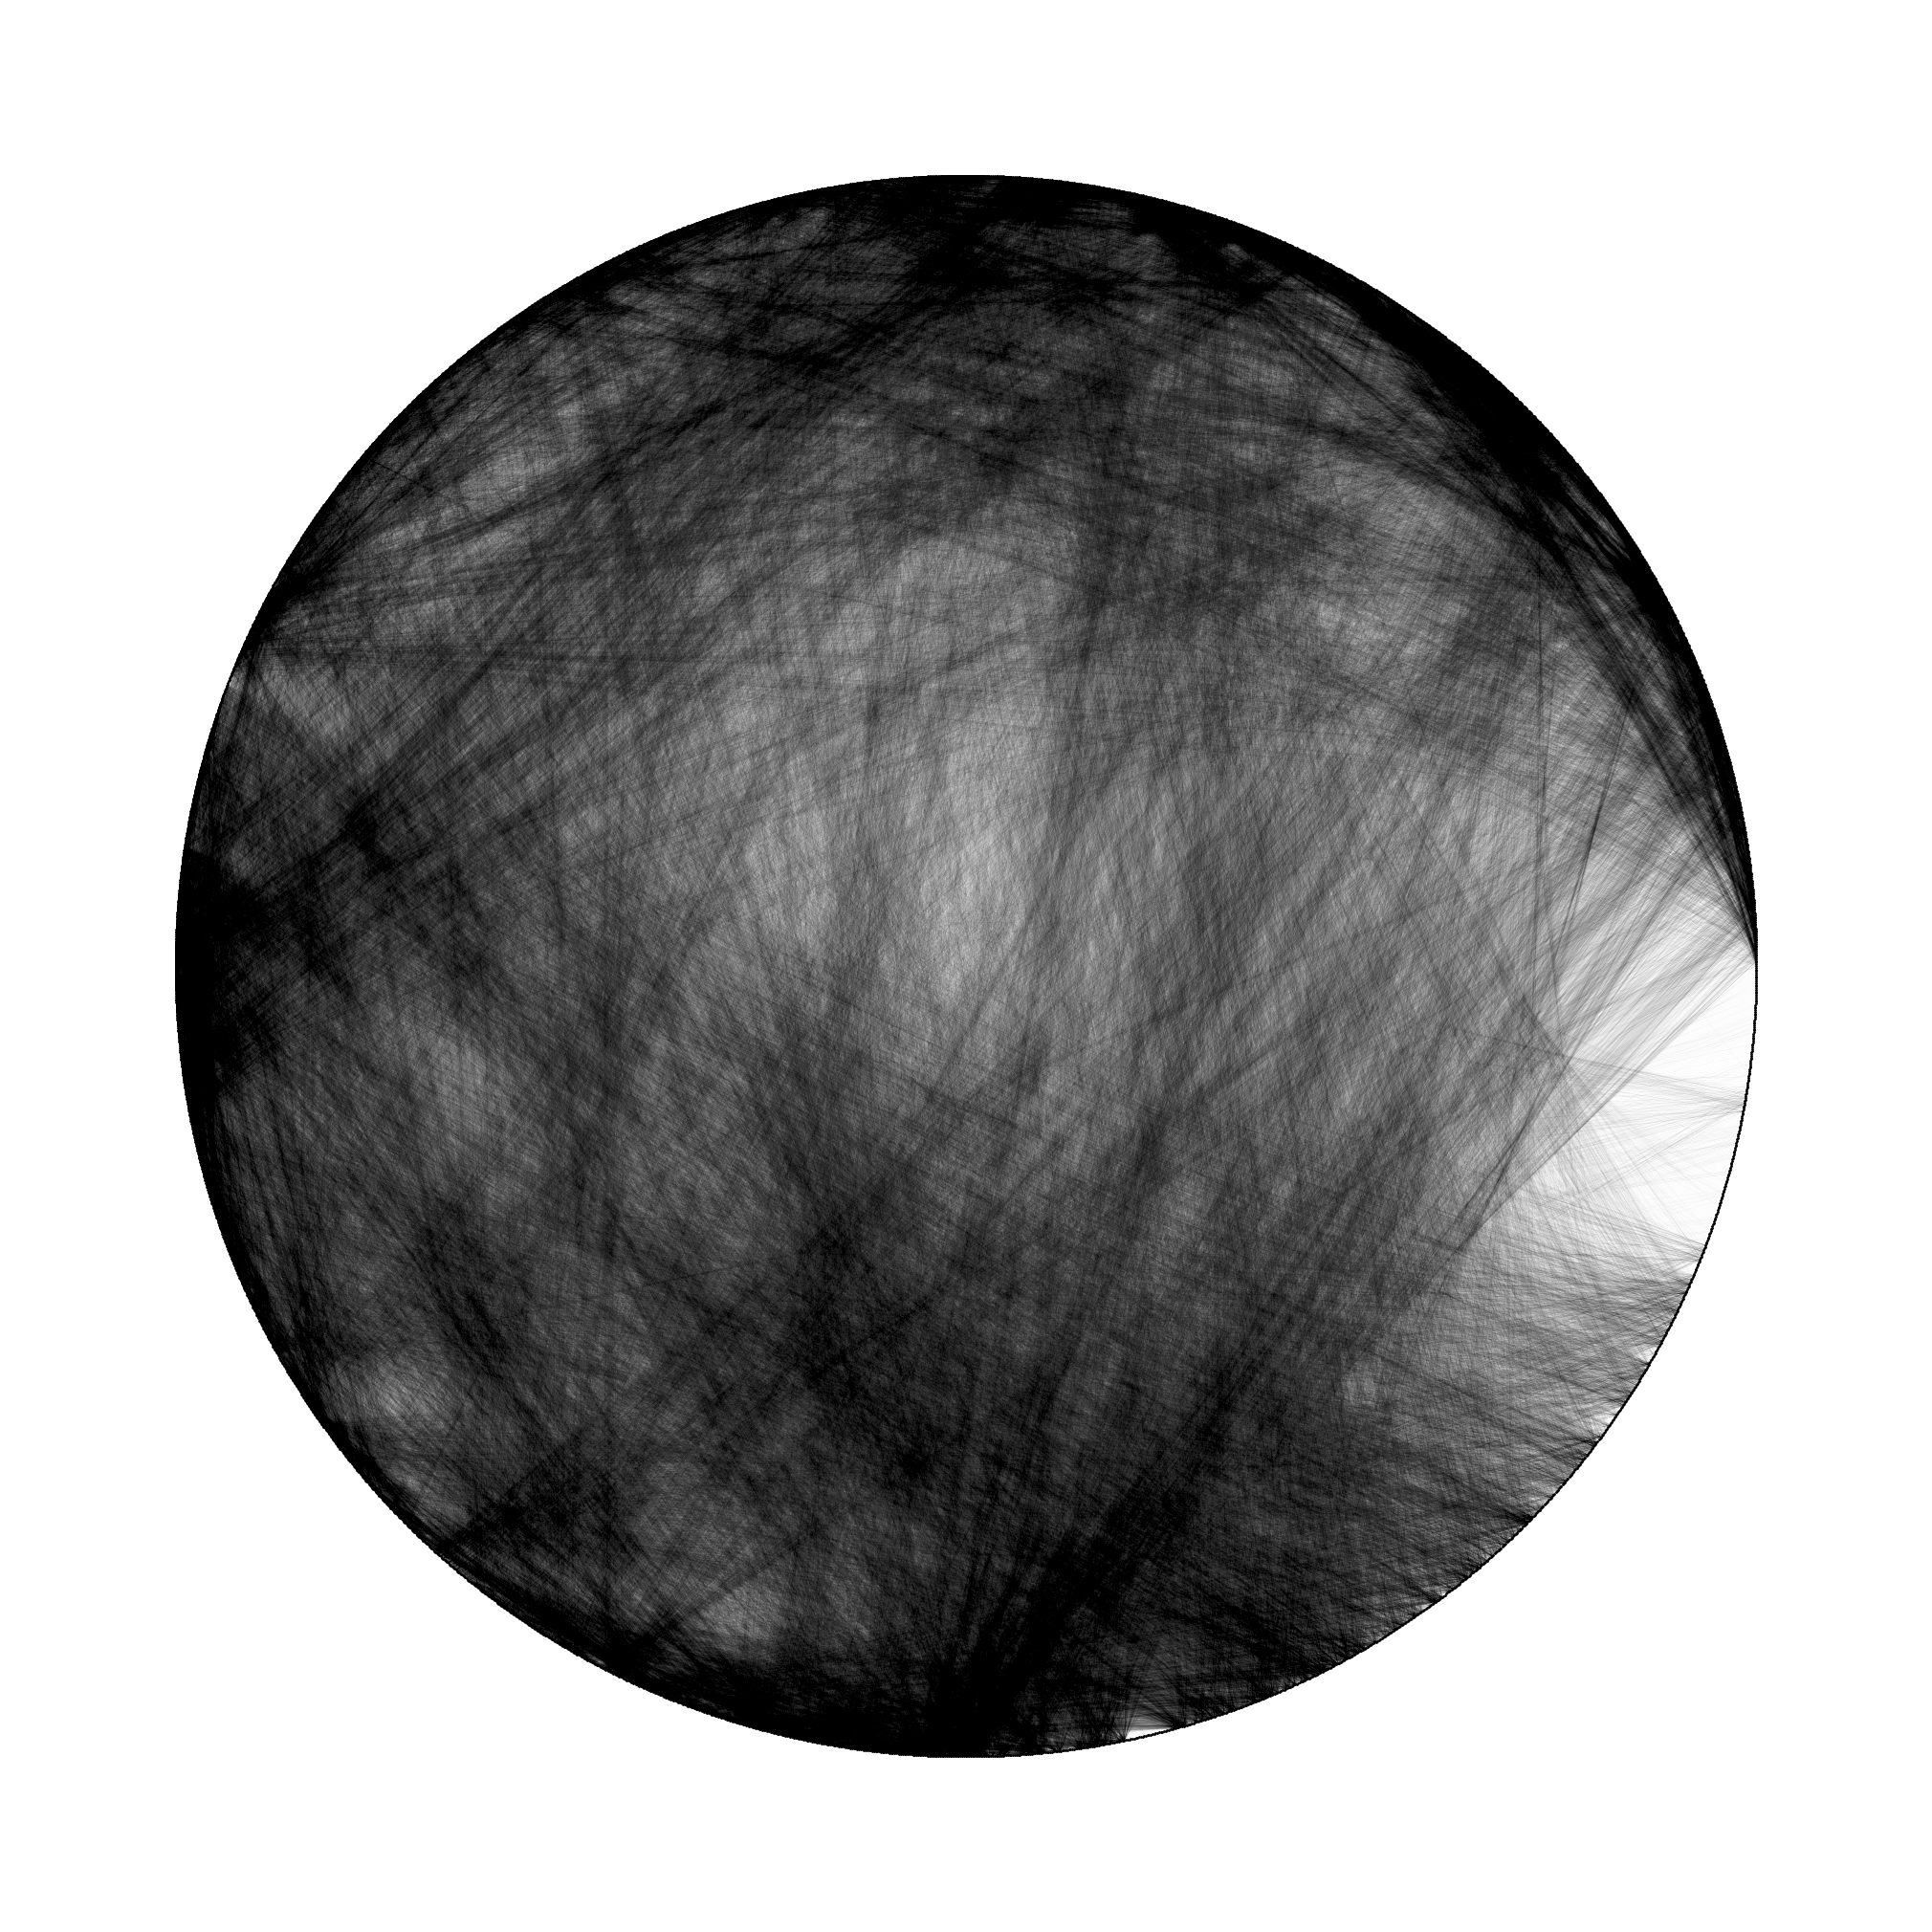

In [39]:
# draw the network
plt.figure(figsize=(20,20))

pos = nx.circular_layout(G)

options = {
    'node_color': 'black',
    'node_size': 1,
    'width': 0.01
}
# Draw custom labels
nx.draw(G, with_labels=False,pos=pos,**options)

plt.savefig(f"./pics/{'simpCompetitionNetwork.png' if USE_SIMPLE_DATA else 'rawCompetitionNetwork.png'}")

# average connection strength between cluster

In [40]:
# caculate the cluster transfer matrix
clusterTransfer = [[[] for i in range(8)] for j in range(7)]
for node in G.nodes():
    sumofconnection = 0
    temp = [[] for _ in range(8)]
    if int(G.nodes[node]['cluster']) != 8:
        for neighbor in G.neighbors(node):
            sumofconnection += G.edges[node,neighbor]['weight']
        for neighbor in G.neighbors(node):
            temp[G.nodes[neighbor]['cluster'] - 1].append(G.edges[node,neighbor]['weight'])
        for i in range(8):
            if len(temp[i]) == 0:
                temp[i] = 0
            temp[i] = np.nanmean(temp[i])
            if temp[i] not in [np.nan,np.inf,-np.inf]:
                clusterTransfer[int(G.nodes[node]['cluster']) - 1][i].append(temp[i])
            

In [41]:

clusterMatrix = np.zeros((7,8))
for i in range(7):
    for j in range(8):
        clusterMatrix[i][j] = np.nanmean(clusterTransfer[i][j])

<Figure size 3000x3000 with 0 Axes>

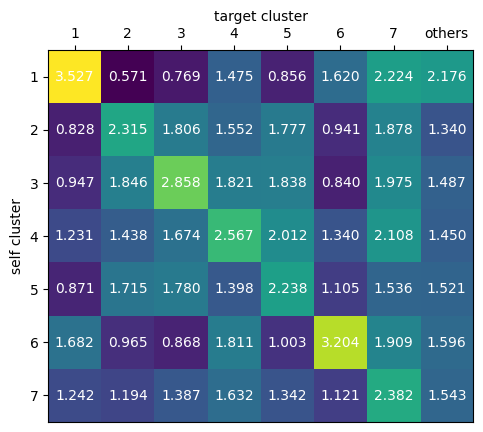

In [42]:
# draw the cluster transfer matrix
plt.figure(figsize=(30,30))
plt.matshow(clusterMatrix, cmap='viridis')
for (i, j), val in np.ndenumerate(clusterMatrix):
    plt.text(j, i, f'{val:.3f}', ha='center', va='center', color='white')

x_labels = ['1', '2', '3', '4', '5', '6', '7', 'others']
plt.xticks(range(len(x_labels)), x_labels)
plt.yticks(range(7), [_ for _ in range(1, 8)])
plt.ylabel('self cluster')
plt.xlabel('target cluster')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.savefig(f"./pics/{'simpClusterStrengthMatrix.png' if USE_SIMPLE_DATA else 'rawClusterStrengthMatrix.png'}")

# average transfer connection between clusters

In [43]:
# caculate the cluster transfer matrix
clusterTransfer = [[[] for i in range(8)] for j in range(7)]
for node in G.nodes():
    sumofconnection = 0
    temp = [[] for _ in range(8)]
    if int(G.nodes[node]['cluster']) != 8:
        for neighbor in G.neighbors(node):
            try:
                temp[G.nodes[neighbor]['cluster'] - 1].append(G.edges[node,neighbor]['weight'])
                sumofconnection += G.edges[node,neighbor]['weight']
            except IndexError:
                pass
        for i in range(8):
            temp[i] = np.sum(temp[i])
            clusterTransfer[int(G.nodes[node]['cluster']) - 1][i].append(temp[i]/sumofconnection)
        
    

clusterMatrix = np.zeros((7,8))
for idxr,row in enumerate(clusterTransfer):
    for idxc,colist in enumerate(row):
        clusterMatrix[idxr][idxc] = np.nanmean(colist)
    


/var/folders/3p/81nnp2994m19w63h0mm8m4bc0000gn/T/ipykernel_81692/1139136770.py:15: RuntimeWarning: invalid value encountered in scalar divide
  clusterTransfer[int(G.nodes[node]['cluster']) - 1][i].append(temp[i]/sumofconnection)


<Figure size 3000x3000 with 0 Axes>

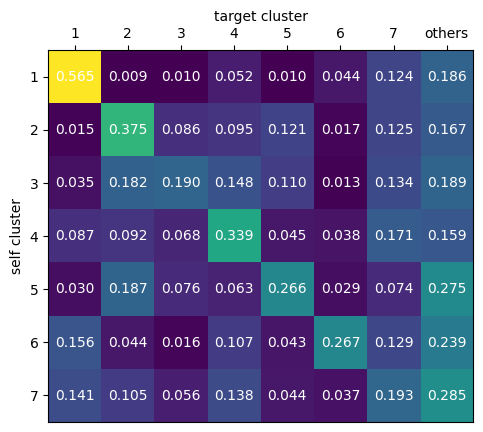

In [44]:
# draw the cluster transfer matrix
plt.figure(figsize=(30,30))
plt.matshow(clusterMatrix, cmap='viridis')
for (i, j), val in np.ndenumerate(clusterMatrix):
    plt.text(j, i, f'{val:.3f}', ha='center', va='center', color='white')

x_labels = ['1', '2', '3', '4', '5', '6', '7', 'others']
plt.xticks(range(len(x_labels)), x_labels)
plt.yticks(range(7), [_ for _ in range(1, 8)])
plt.ylabel('self cluster')
plt.xlabel('target cluster')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.savefig(f"./pics/{'simpClusterStrengthMatrix.png' if USE_SIMPLE_DATA else 'rawClusterStrengthMatrix.png'}")

<Figure size 3000x3000 with 0 Axes>

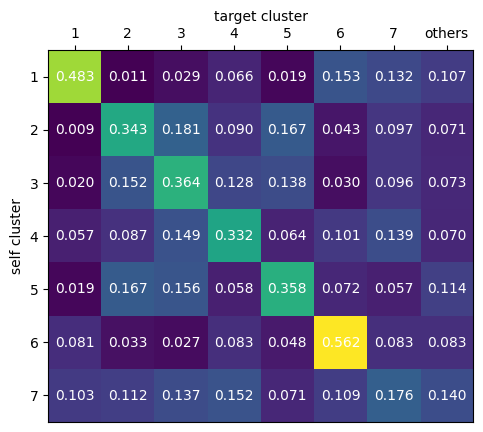

In [45]:
# adjest by size
sizemap = clusterData.groupby('cluster').size().to_dict()
sizemap[8] = len(G.nodes) - len(clusterData)
adjMatrix = np.zeros((7,8))
for i in range(7):
    for j in range(8):
        adjMatrix[i][j] = clusterMatrix[i][j] / sizemap[j+1]
rowsum = np.sum(adjMatrix,axis=1)
for i in range(7):
    for j in range(8):
        adjMatrix[i][j] = adjMatrix[i][j] / rowsum[i]

# draw the cluster transfer matrix
plt.figure(figsize=(30,30))
plt.matshow(adjMatrix, cmap='viridis')
for (i, j), val in np.ndenumerate(adjMatrix):
    plt.text(j, i, f'{val:.3f}', ha='center', va='center', color='white')
plt.xticks(range(len(x_labels)), x_labels)
plt.yticks(range(7), [_ for _ in range(1, 8)])
plt.ylabel('self cluster')
plt.xlabel('target cluster')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.savefig("./pics/adjClusterStrengthMatrix.png" if USE_SIMPLE_DATA else "./pics/rawAdjClusterStrengthMatrix.png")